# Online Retail Customer Segmentation Project

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [1]:
# importing the libraries

# for data manipulation and analysis
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for scaling
from sklearn.preprocessing import StandardScaler

# for K-Means clustering
from sklearn.cluster import KMeans

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the dataset
retail_data = pd.read_excel('Online Retail.xlsx')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail_data.shape

(541909, 8)

In [4]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Data Cleaning

### Removing all duplicate entries

In [6]:
retail_data.duplicated().sum()

5268

In [7]:
# removing all duplicate transactions
retail_data = retail_data[~retail_data.duplicated()]
retail_data.shape

(536641, 8)

### Removing transactions with no customer id

In [8]:
# removing transaction with no customer id
retail_data = retail_data.dropna()
retail_data.shape

(401604, 8)

Invoice No

In [9]:
# Invoice number that starts with letter 'c', indicates a cancellation.
# So, we remove all such cancelled orders from the dataset
retail_data = retail_data[retail_data['InvoiceNo'].str.startswith('C')!=True]
retail_data.shape

(392732, 8)

In [10]:
# no. of unique transactions
retail_data['InvoiceNo'].nunique()

18536

StockCode

In [11]:
# no. of unique products sold by the retailer
retail_data['StockCode'].nunique()

3665

In [12]:
retail_data['StockCode'].value_counts().head(10)

85123A    2023
22423     1714
85099B    1615
84879     1395
47566     1390
20725     1304
22720     1152
POST      1099
23203     1091
20727     1078
Name: StockCode, dtype: int64

In [13]:
retail_data.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


Unit Price and Quantity

In [14]:
# we will only consider transactions that have unit price greater than 0
retail_data = retail_data[retail_data['UnitPrice']>0]
retail_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,392692.0,13.119702,180.492832,1.000,2.00,6.00,12.00,80995.00
UnitPrice,392692.0,3.125914,22.241836,0.001,1.25,1.95,3.75,8142.75
CustomerID,392692.0,15287.843865,1713.539549,12346.000,13955.00,15150.00,16791.00,18287.00


In [15]:
retail_data.shape

(392692, 8)

In [16]:
retail_data['CustomerID'].nunique()

4338

# Cohort Analysis

Cohort analysis is done to understand how different customers interact with different products and use those insights to retain those customers. Customer retention is a very useful metric to understand how many of all the customers are still active. It is calculated as percentage of active customers out of total customers.

In [30]:
# define a function that will parse the date
import datetime as dt
def get_month(x): return dt.datetime(x.year, x.month, 1)

# create InvioceDay column
retail_data['InvoiceMonth'] = retail_data['InvoiceDate'].apply(get_month)

# create a groupby object that groups CustomerID variable, and selects InvoiceDay for further calculations
grouping = retail_data.groupby('CustomerID')['InvoiceMonth']

# Assign a minimum InvoiceDay value to the dataset
retail_data['CohortMonth'] = grouping.transform('min')

retail_data.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,2011-08-18,112,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,2011-08-18,112,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,2011-08-18,112,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,2011-08-18,112,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-09,2011-08-18,112,2011-12-01,2011-08-01


In [31]:
def get_month_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [33]:
# get the integers for date parts from the InvoiceDay column
invoice_year, invoice_month, _ = get_month_int(retail_data, 'InvoiceMonth')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_month_int(retail_data, 'CohortMonth')

In [34]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
retail_data['CohortIndex'] = years_diff * 12 + months_diff + 1
retail_data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,2011-08-18,5,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,2011-08-18,5,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,2011-08-18,5,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,2011-08-18,5,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-09,2011-08-18,5,2011-12-01,2011-08-01


We will calculate the following cohort metrics
1. Retention Rate per cohort
2. Average Quantity per cohort
3. Average price per cohort
4. Average amount spend per cohort

In [35]:
#Count monthly active customers from each cohort
grouping = retail_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# cohort metrics : calculating retention rate
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.date

In [54]:
#Average quantity for each cohort
grouping_1 = retail_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_1['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

In [56]:
#Average unit price for each cohort
grouping_2 = retail_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_2['UnitPrice'].mean()
cohort_data = cohort_data.reset_index()
average_price = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date

In [61]:
# total amount spent on every transaction 
retail_data['Amount'] = retail_data['Quantity']*retail_data['UnitPrice']
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex,InvoiceMonth,CohortMonth,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01,20.34


In [62]:
#Average amount spent for each cohort
grouping_3 = retail_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_3['Amount'].mean()
cohort_data = cohort_data.reset_index()
average_amount = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Amount')
average_amount.round(1)
average_amount.index = average_amount.index.date

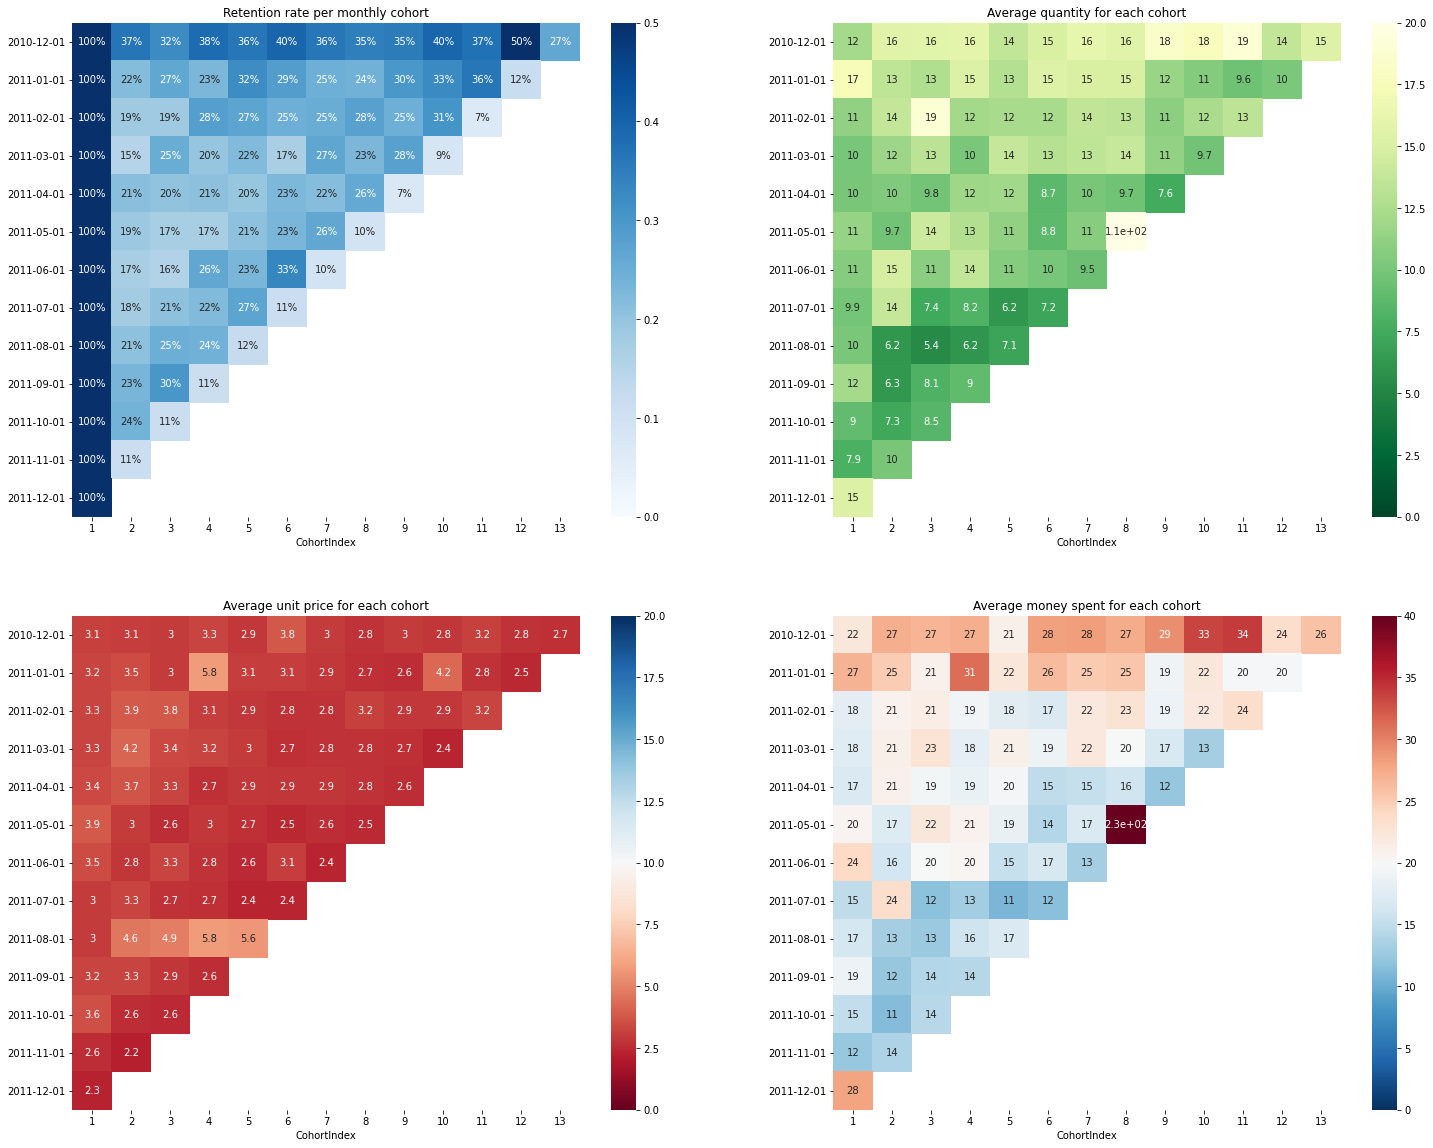

In [64]:
# constructing the heatmap
plt.figure(figsize=(25,20))

plt.subplot(221)
plt.title("Retention rate per monthly cohort")
sns.heatmap(retention, annot=True,fmt='.0%', vmin = 0.0,vmax =0.5,cmap="Blues")

plt.subplot(222)
plt.title("Average quantity for each cohort")
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="YlGn_r")

plt.subplot(223)
plt.title("Average unit price for each cohort")
sns.heatmap(data=average_price,annot = True,vmin = 0.0,vmax =20,cmap="RdBu")

plt.subplot(224)
plt.title("Average money spent for each cohort")
sns.heatmap(data=average_amount,annot = True,vmin = 0.0,vmax =40,cmap="RdBu_r")

plt.show()

The above heatmaps shows the following :
1. Retention rate falls drastically after the first month from December, 2010.
2. Average quantity of product sold increased for months  Jan, Feb 2011 and reduced gradually for July and August of 2011.
3. In the 4th heatmap, we can see that the average amount spent by the group of customers is initially 27 in Jan'2011 but after one month they spent 25, lower than the previous, then they spend 21 after two months and so on.

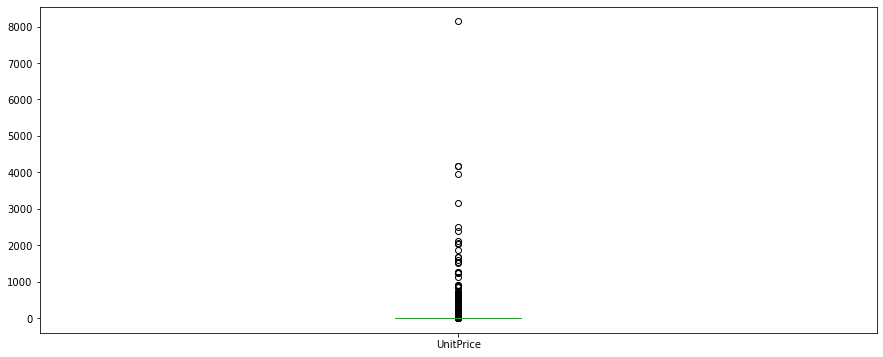

In [66]:
retail_data['UnitPrice'].plot.box(figsize=(15,6))
plt.show()